---
title: "Quiz 4 Solution"
format:
  html:
    toc: true
    toc-title: Contents
    toc-depth: 4
    code-fold: show
    self-contained: true
jupyter: python3
---

# Regularized Cost and Gradient

## Goals
In this lab, you will:
* Extend the previous linear cost functions with a regularization term to prevent overfitting
* Implement gradient descent with L1 and L2 regularizition for linear regression using Vectorization
* Utilize Lasso, Ridge from scikit-learn to implement regularized linear regression
* Compare the parameters learned from different approaches and their performance

### Importing necessary libaries

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy, math
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler

### Creating data for building a overfitting linear model

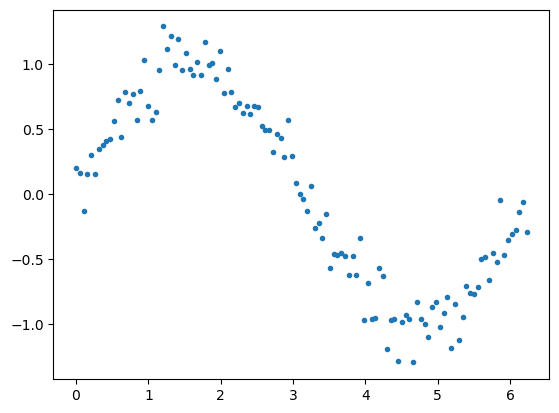

In [37]:
#Define input array with angles from 60deg to 300deg converted to radians
x = np.array([i*np.pi/60 for i in range(120)])
# x = np.array([i*np.pi/180 for i in range(360)])

np.random.seed(10)  #Setting seed for reproducibility
y = np.sin(x) + np.random.normal(0,0.15,len(x))
data = pd.DataFrame(np.column_stack([x,y]),columns=['x','y'])
plt.plot(data['x'],data['y'],'.')
plt.show()

In [38]:
for i in range(2,16):  #power of 1 is already there
    colname = 'x_%d'%i      #new var will be x_power
    data[colname] = data['x']**i
print(data.head())

         x         y       x_2       x_3       x_4           x_5  \
0  0.00000  0.199738  0.000000  0.000000  0.000000  0.000000e+00   
1  0.05236  0.159628  0.002742  0.000144  0.000008  3.935438e-07   
2  0.10472 -0.127282  0.010966  0.001148  0.000120  1.259340e-05   
3  0.15708  0.155177  0.024674  0.003876  0.000609  9.563115e-05   
4  0.20944  0.301112  0.043865  0.009187  0.001924  4.029889e-04   

            x_6           x_7           x_8           x_9          x_10  \
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1  2.060591e-08  1.078923e-09  5.649226e-11  2.957928e-12  1.548767e-13   
2  1.318778e-06  1.381021e-07  1.446202e-08  1.514459e-09  1.585938e-10   
3  1.502171e-05  2.359604e-06  3.706457e-07  5.822090e-08  9.145317e-09   
4  8.440179e-05  1.767707e-05  3.702277e-06  7.754031e-07  1.624000e-07   

           x_11          x_12          x_13          x_14          x_15  
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.00000

In [39]:
# split into train and test 
np.random.seed(123)
# split the data into train and test, less data is prone to overfitting, so we will only use  10% data for training
mask = np.random.rand(len(data)) < 0.1
train = data[mask]
test = data[~mask]
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))

Number of observations in the training data: 7
Number of observations in the test data: 113


In [40]:
# split feature and target
X_train = train.drop('y', axis=1).values
y_train = train['y'].values
X_test = test.drop('y', axis=1).values
y_test = test['y'].values

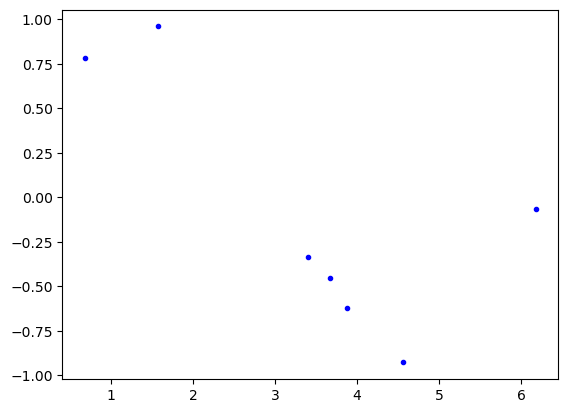

In [41]:
plt.plot(X_train[:,0], y_train, 'b.')   

As can be observed above, we only have 7 instances in the training data, so the polynominal regression will easily overfit.

In [42]:
# do standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Gradient Descent using Vectorization
Below is the GD implementation you did in your last quiz

In [43]:
#Function to calculate the cost
def compute_cost_matrix(X, y, w):
    """
    Computes the gradient for linear regression
     Args:
      X (ndarray (m,n+1)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n+1,)) : model parameters  
    Returns
      cost: (scalar)
    """
    # use vectorization to implement the cost for linear regression
    m = X.shape[0]  # m = len(y)

    # calculate f_wb for all examples.
    f_wb = X @ w
    # calculate cost
    cost = (1/(2*m)) * np.sum((f_wb-y)**2)
    return cost

In [44]:
def compute_gradient_matrix(X, y, w):
    """
    Computes the gradient for linear regression

    Args:
      X (ndarray (m,n+1)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n+1,)) : model parameters  
    Returns
      dj_dw (ndarray (n+1,1)): The gradient of the cost w.r.t. the parameters w.
    """
    # use vectorization to implement the gradient for linear regression
    m = len(y)
    f_wb = X @ w
    # f_wb = np.dot(X, w)
    e   = f_wb - y
    dj_dw  = (1/m) * (X.T @ e)

    return dj_dw

To show the overfitting issue, I added X_test, y_test in the parameters

In [45]:
def gradient_descent_matrix(X, y, X_test, y_test, w_in, alpha, num_iters): 
    """
    Performs batch gradient descent to learn w. Updates w by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X (ndarray (?,n+1))   : Training set, ? examples with n features
      y (ndarray (?,))    : target values in test set
      X_test (ndarray (?,n+1))   : Test set, ? examples with n features
      y_test (ndarray (?,))    : target values in test set
      w_in (ndarray (n+1,)) : initial model parameters  
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n+1,)) : Updated values of parameters
      J_history           : Cost of the model on the training set after each iteration
      test_J_history      : Cost of the model on test set after each iteration
      """
    
    # implement the batch gradient descent algorithm using the compute_gradient and compute_cost functions
    w = copy.deepcopy(w_in)
    J_history = []
    test_J_history = []
    for i in range(num_iters):
        w = w - alpha * compute_gradient_matrix(X, y, w)
        J_history.append(compute_cost_matrix(X, y, w))
        test_J_history.append(compute_cost_matrix(X_test, y_test, w))

        # print cost every 100 iterations
        if i % 1000 == 0:
            print("Iteration: ", i, " Cost: ", J_history[i], " Test Cost: ", test_J_history[i])
    return w, J_history, test_J_history

In [46]:
# Do the gradient descent with the scaled data
# add a column of ones to the X_train
X_train_scaled_1 = np.column_stack((np.ones(len(X_train_scaled)), X_train_scaled))
X_test_scaled_1 = np.column_stack((np.ones(len(X_test_scaled)), X_test_scaled))

w_in = np.zeros(X_train_scaled_1.shape[1])
alpha = 0.1
num_iters = 50000
w, J_history, test_J_history = gradient_descent_matrix(X_train_scaled_1, y_train, X_test_scaled_1, y_test, w_in, alpha, num_iters)


Iteration:  0  Cost:  0.1866960528996568  Test Cost:  0.2092898934425311
Iteration:  1000  Cost:  0.00892025060462924  Test Cost:  0.07780092541033455
Iteration:  2000  Cost:  0.007653845413069761  Test Cost:  0.06628499187322841
Iteration:  3000  Cost:  0.00658567926544479  Test Cost:  0.05717185615074202
Iteration:  4000  Cost:  0.0056840371456868075  Test Cost:  0.050135052445456255
Iteration:  5000  Cost:  0.004922920082954787  Test Cost:  0.04479674478159611
Iteration:  6000  Cost:  0.004280392611234649  Test Cost:  0.04083842907889705
Iteration:  7000  Cost:  0.0037379434138849494  Test Cost:  0.03799578170458268
Iteration:  8000  Cost:  0.0032799507819497023  Test Cost:  0.03604988093933046
Iteration:  9000  Cost:  0.002893231547439497  Test Cost:  0.034819755038898975
Iteration:  10000  Cost:  0.0025666604281511943  Test Cost:  0.034156138103249925
Iteration:  11000  Cost:  0.0022908487925964913  Test Cost:  0.033936230132244276
Iteration:  12000  Cost:  0.002057873569585191  T

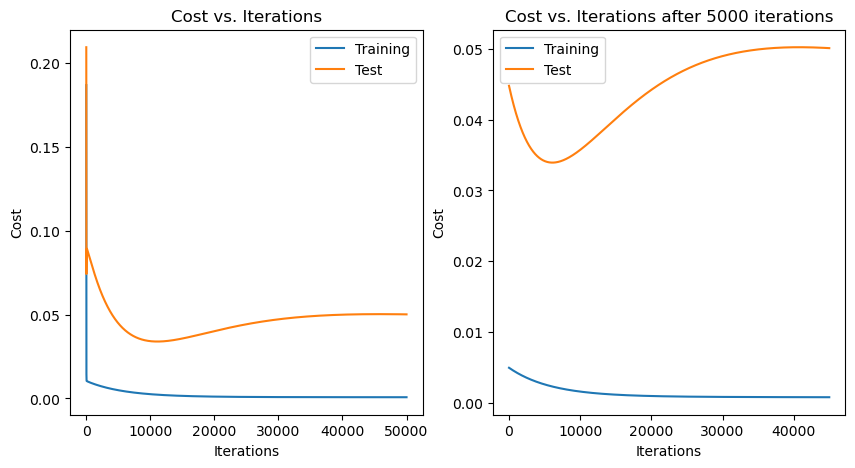

In [47]:
# putting the learning curve to show the overfitting issue of the model
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(J_history, label='Training')
axs[0].plot(test_J_history, label='Test')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Cost')
axs[0].set_title('Cost vs. Iterations')
axs[0].legend()

axs[1].plot(J_history[5000:], label='Training')
axs[1].plot(test_J_history[5000:], label='Test')
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('Cost')
axs[1].set_title('Cost vs. Iterations after 5000 iterations')
axs[1].legend()

plt.show()

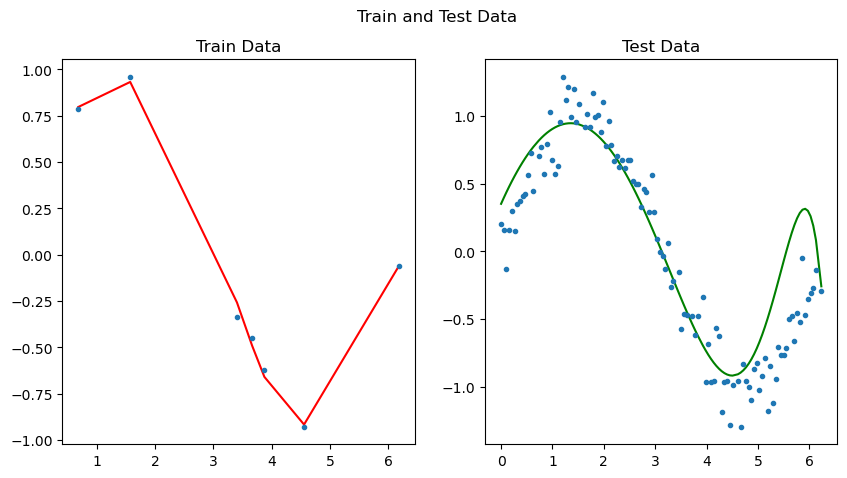

In [48]:
# plot the model on the train and test data
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Train and Test Data')
axs[0].plot(X_train[:, 0:1], X_train_scaled_1 @ w, 'r')
axs[0].plot(X_train[:, 0:1], y_train, '.')
axs[0].set_title('Train Data')
axs[1].plot(X_test[:, 0:1], X_test_scaled_1 @ w, 'g')
axs[1].plot(X_test[:, 0:1], y_test, '.')
axs[1].set_title('Test Data')
plt.show()


In [49]:
# output the final RMSE for the training and test set
gd_rmse_train = math.sqrt(J_history[-1])
gd_rmse_test = math.sqrt(test_J_history[-1])
print("Final training RMSE: ",gd_rmse_train)
print("Final test RMSE: ", gd_rmse_test)

Final training RMSE:  0.027505148937302167
Final test RMSE:  0.2238833286495721


As can be seen, the model overfits the training set and could not generalizes well on the test set. Next, let's add regularization to fix the issue

## Adding Regularization

<b>Cost function for L2 regularized linear regression</b>
\begin{equation}
J(w) = 1/2m \sum_{i=1}^{m} (f_{\mathbf{w}}(\mathbf{x})^{(i)} - y^{(i)})^2 +\lambda/2m\sum_{j=1}^{n} w_j^2  
\end{equation}

<b>Cost function for L1 regularized linear regression</b>
\begin{equation}
J(w) = 1/2m \sum_{i=1}^{m} (f_{\mathbf{w}}(\mathbf{x})^{(i)} - y^{(i)})^2 +\lambda/2m\sum_{j=1}^{n} |w_j|
\end{equation}


where:
$$ f_{\mathbf{w}}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)}  \tag{2} $$ 


Compare this to the cost function without regularization (which you implemented in  a previous lab), which is of the form:

$$J(\mathbf{w}) = \frac{1}{2m} \sum\limits_{i = 1}^{m} (f_{\mathbf{w}}(\mathbf{x}^{(i)}) - y^{(i)})^2 $$ 

The difference is the regularization term,  <span style="color:red">
    $\frac{\lambda}{2m}  \sum_{j=1}^{n} w_j^2$ </span> and <span style="color:red">
    $\frac{\lambda}{2m} \sum_{j=1}^{n} |w_j|$ 
    
Including this term encourages gradient descent to minimize the size of the parameters. Note, in this example, the parameter $w_0$ is not regularized. This is standard practice.

## Using L2 regularization to fix the overfitting issue

In [50]:
# Function to calculate the cost with L2 regularization
def compute_cost_matrix_reg(X, y, w, lambda_reg):
    """
    Computes the cost for linear regression with L2 regularization
    
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters
      lambda_reg (float): regularization parameter
      
    Returns
      cost: (scalar)
    """
    # use vectorization to implement the cost for linear regression with L2 regularization, do not regularize the bias term
    m = X.shape[0]  # m = len(y)
    f_wb = X @ w
    cost = (1/(2*m)) * np.sum((f_wb-y)**2) + (lambda_reg/(2*m)) * np.sum(w[1:]**2)
    return cost


### Computing the Gradient with L2 regularization 

\begin{equation}
\frac{\partial J(w)}{\partial w_j} = 1/m\sum_{i=1}^{m}(f_{\mathbf{w}}(\mathbf{x})^{(i)} - y^{(i)}).w_j^{(i)} + (\lambda/m)x_j^{(i)}
\end{equation}

    
The term which adds regularization is  the <span style="color:red"> 
$\frac{\lambda}{m} w_j ^{(i)}$</span>, the parameter $w_0$ is not regularized

## Gradient descent with regularization
The basic algorithm for running gradient descent does not change with regularization, it is:
$$\begin{align*}
&\text{repeat until convergence:} \; \lbrace \\
&  \; \; \;w_j = w_j -  \alpha \frac{\partial J(\mathbf{w})}{\partial w_j} \tag{1}  \; & \text{for j := 0..n} \\ 
&\rbrace
\end{align*}$$
Where each iteration performs simultaneous updates on $w_j$ for all $j$.

What changes with regularization is computing the gradients.

### Task 17:Gradient function for regularized linear regression


In [51]:
# Function to calculate the gradient with L2 regularization
def compute_gradient_matrix_reg(X, y, w, lambda_reg):
    """
    Computes the gradient for linear regression with L2 regularization
    
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters
      lambda_reg (float): regularization parameter
      
    Returns
      dj_dw (ndarray (n,1)): The gradient of the cost w.r.t. the parameters w.
    """
    # use vectorization to implement the gradient for linear regression with L2 regularization, do not regularize the bias term
    m = len(y)
    f_wb = X @ w
    e   = f_wb - y
    # dj_dw  = (1/m) * (X.T @ e) + (lambda_reg/m) * np.concatenate((np.zeros(1), w[1:]))
    dj_dw  = (1/m) * (X.T @ e) + lambda_reg * np.concatenate((np.zeros(1), w[1:]))
    return dj_dw


In [52]:
# Function to perform gradient descent with L2 regularization
def gradient_descent_matrix_reg(X, y, X_test, y_test, w_in, alpha, num_iters, lambda_reg):
    """
    Performs batch gradient descent to learn w. Updates w by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X (ndarray (m,n))   : Data, m examples with n features
      y (ndarray (m,))    : target values
      w_in (ndarray (n+1,)) : initial model parameters  
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent
      lambda_reg (float)  : regularization parameter
      
    Returns:
      w (ndarray (n+1,)) : Updated values of parameters
      J_history           : Cost of the model after each iteration
      """
    
    # implement the batch gradient descent algorithm using the compute_gradient and compute_cost functions
    w = copy.deepcopy(w_in)
    J_history = []
    test_J_history = []
    for i in range(num_iters):
        w = w - alpha * compute_gradient_matrix_reg(X, y, w, lambda_reg)
        J_history.append(compute_cost_matrix_reg(X, y, w, lambda_reg))
        test_J_history.append(compute_cost_matrix_reg(X_test, y_test, w, lambda_reg))

        # print cost every 100 iterations
        if i % 5000 == 0:
            print("Iteration: ", i, " Cost: ", J_history[i], " Test Cost: ", test_J_history[i])
    return w, J_history, test_J_history

In [53]:
# initialize the model parameters to 0
w = np.zeros(X_train_scaled_1.shape[1])
# run the gradient descent algorithm for 1000 iterations with a learning rate of 0.01 and lambda = 0.1
alpha = 0.1
num_iters = 60000
GD_L2_w, J_history, test_J_history = gradient_descent_matrix_reg(X_train_scaled_1, y_train, X_test_scaled_1, y_test, w, alpha, num_iters, 0.004)
print(f"w found by gradient descent with regularization: {GD_L2_w} ")



Iteration:  0  Cost:  0.18669731696495603  Test Cost:  0.20928997174746114
Iteration:  5000  Cost:  0.006214499904625434  Test Cost:  0.04858707543664691
Iteration:  10000  Cost:  0.005160631752481926  Test Cost:  0.0378742248113893
Iteration:  15000  Cost:  0.004904951276615564  Test Cost:  0.0351601702560985
Iteration:  20000  Cost:  0.004842613443488992  Test Cost:  0.03439816905020166
Iteration:  25000  Cost:  0.00482724397713462  Test Cost:  0.03413428292430608
Iteration:  30000  Cost:  0.004823360019246754  Test Cost:  0.03401283956492709
Iteration:  35000  Cost:  0.004822326704682285  Test Cost:  0.03394212860324044
Iteration:  40000  Cost:  0.004822024105058547  Test Cost:  0.033895279497818065
Iteration:  45000  Cost:  0.004821921435455811  Test Cost:  0.03386239367464534
Iteration:  50000  Cost:  0.004821880118909504  Test Cost:  0.03383870587120554
Iteration:  55000  Cost:  0.004821860912402864  Test Cost:  0.033821418455904834
w found by gradient descent with regularization

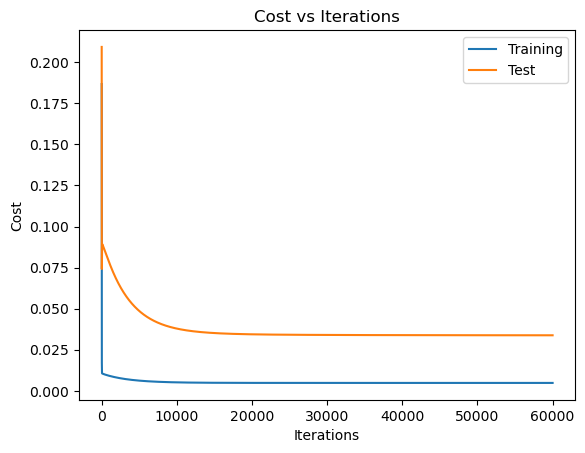

In [54]:
# plot the cost over the iterations
plt.plot(J_history, label='Training')
plt.plot(test_J_history, label='Test')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs Iterations')
plt.legend()
plt.show()

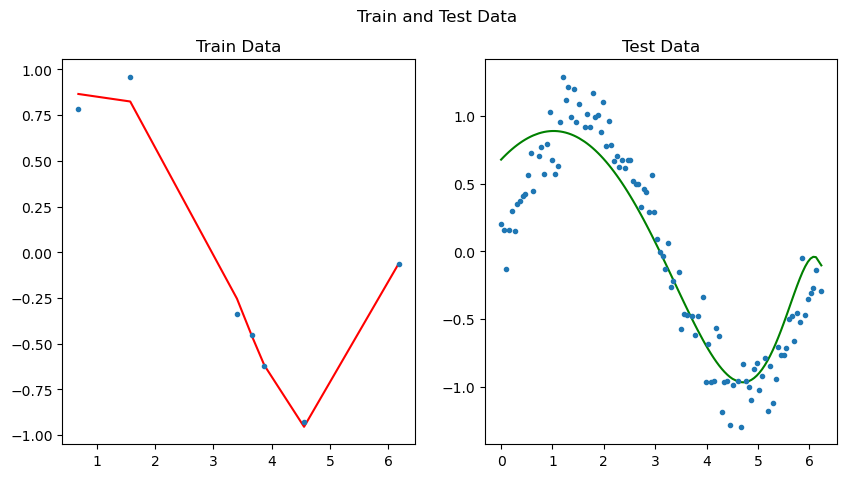

In [55]:
# putting the above figures side by side for comparision, using subplots
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Train and Test Data')
axs[0].plot(X_train[:, 0:1], X_train_scaled_1 @ GD_L2_w, 'r')
axs[0].plot(X_train[:, 0:1], y_train, '.')
axs[0].set_title('Train Data')
axs[1].plot(X_test[:, 0:1], X_test_scaled_1 @ GD_L2_w, 'g')
axs[1].plot(X_test[:, 0:1], y_test, '.')
axs[1].set_title('Test Data')
plt.show()


In [56]:
# output the final RMSE for the training and test set
gd_l2_rmse_train = math.sqrt(J_history[-1])
gd_l2_rmse_test = math.sqrt(test_J_history[-1])
print("Final training RMSE: ",gd_l2_rmse_train)
print("Final test RMSE: ", gd_l2_rmse_test)

Final training RMSE:  0.06943955011153133
Final test RMSE:  0.18387143940522035


## Using L1 Regularization to fix the overfitting issue

The L1 gradient formula can be found in the slides.

Using gradient descent to optimize L1 regularization in linear regression (i.e., Lasso regression) can encounter some challenges and issues:

* **Non-differentiability**: The L1 regularization term is not differentiable at zero At zero, the gradient becomes undefined, making it difficult to find a direction to update the coefficients, causing gradient descent get stuck in the region.


* **Coordinate Descent**: Coordinate descent, a variant of gradient descent, is often used for Lasso regression because it can handle the non-differentiability issue by updating one coefficient at a time. This makes it more suitable for optimizing L1 regularization.

Despite these challenges, gradient descent can still be an effective optimization method for Lasso regression, especially when combined with strategies like coordinate descent or stochastic gradient descent. However, it's essential to be aware of these issues and use appropriate techniques to address them for efficient optimization of L1 regularization in linear regression.

Next, let's implement L1 regularization and run it on our dataset to see if it helps alleviate the overfitting issue.

In [57]:
# Function to calculate the cost with L1 regularization
def compute_cost_matrix_reg_l1(X, y, w, lambda_reg):
    """
    Computes the cost for linear regression with L1 regularization
    
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters
      lambda_reg (float): regularization parameter
      
    Returns
      cost: (scalar)
    """
    # use vectorization to implement the cost for linear regression with L1 regularization, do not regularize the bias term
    m = X.shape[0]  # m = len(y)
    f_wb = X @ w
    cost = (1/(2*m)) * np.sum((f_wb-y)**2) + (lambda_reg/(2*m)) * np.sum(np.abs(w[1:]))
    return cost

In [58]:
# Function to calculate the gradient with L1 regularization
def compute_gradient_matrix_reg_l1(X, y, w, lambda_reg):
    """
    Computes the gradient for linear regression with L1 regularization
    
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters
      lambda_reg (float): regularization parameter
      
    Returns
      dj_dw (ndarray (n,1)): The gradient of the cost w.r.t. the parameters w.
    """
    # use vectorization to implement the gradient for linear regression with L1 regularization, do not regularize the bias term
    m = len(y)
    f_wb = X @ w
    e   = f_wb - y
    dj_dw  = (1/m) * (X.T @ e) + (lambda_reg/m) * np.concatenate((np.zeros(1), np.sign(w[1:])))
    return dj_dw

In [59]:
# Function to perform gradient descent with L1 regularization
def gradient_descent_matrix_reg_l1(X, y, X_test, y_test, w_in, alpha, num_iters, lambda_reg):
    """
    Performs batch gradient descent to learn w. Updates w by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X (ndarray (m,n))   : Data, m examples with n features
      y (ndarray (m,))    : target values
      w_in (ndarray (n+1,)) : initial model parameters  
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent
      lambda_reg (float)  : regularization parameter
      
    Returns:
      w (ndarray (n+1,)) : Updated values of parameters
      J_history           : Cost of the model after each iteration
      """
    
    # implement the batch gradient descent algorithm using the compute_gradient and compute_cost functions
    w = copy.deepcopy(w_in)
    J_history = []
    test_J_history = []
    for i in range(num_iters):
        w = w - alpha * compute_gradient_matrix_reg_l1(X, y, w, lambda_reg)
        J_history.append(compute_cost_matrix_reg_l1(X, y, w, lambda_reg))
        test_J_history.append(compute_cost_matrix_reg_l1(X_test, y_test, w, lambda_reg))

        # print cost every 100 iterations
        if i % 5000 == 0:
            print("Iteration: ", i, " Cost: ", J_history[i], " Test Cost: ", test_J_history[i])
    return w, J_history, test_J_history

In [60]:
# initialize the model parameters to 0
w = np.zeros(X_train_scaled_1.shape[1])
# run the gradient descent algorithm for 1000 iterations with a learning rate of 0.01 and lambda = 0.1
alpha = 0.1
num_iters = 60000
GD_L1_w, J_history, test_J_history = gradient_descent_matrix_reg_l1(X_train_scaled_1, y_train, X_test_scaled_1, y_test, w, alpha, num_iters, 0.004)
print(f"w found by gradient descent with L1 regularization: {GD_L1_w} ")


Iteration:  0  Cost:  0.18673896644705978  Test Cost:  0.20929255180387465
Iteration:  5000  Cost:  0.007043011972610614  Test Cost:  0.05515723877601205
Iteration:  10000  Cost:  0.005952270987267534  Test Cost:  0.0448752530313636
Iteration:  15000  Cost:  0.005320583758888538  Test Cost:  0.039070898449806664
Iteration:  20000  Cost:  0.004917944864982657  Test Cost:  0.035800026777380756
Iteration:  25000  Cost:  0.004644413921821936  Test Cost:  0.03353596422713397
Iteration:  30000  Cost:  0.004452534314041757  Test Cost:  0.031956841378110626
Iteration:  35000  Cost:  0.004312106647415655  Test Cost:  0.030491676631951754
Iteration:  40000  Cost:  0.004215958900571006  Test Cost:  0.02961583426368716
Iteration:  45000  Cost:  0.004148358670302998  Test Cost:  0.029024262562502984
Iteration:  50000  Cost:  0.004099142297876914  Test Cost:  0.028604443518044927
Iteration:  55000  Cost:  0.004061890424304965  Test Cost:  0.02831595547975415
w found by gradient descent with L1 regul

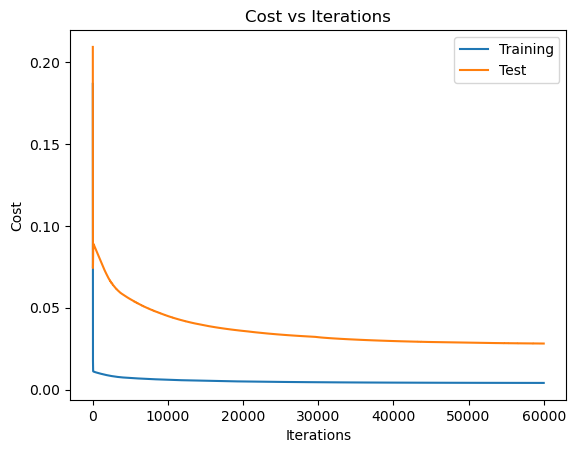

In [61]:
# plot the cost over the iterations
plt.plot(J_history, label='Training')
plt.plot(test_J_history, label='Test')

plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs Iterations')
plt.legend()
plt.show()

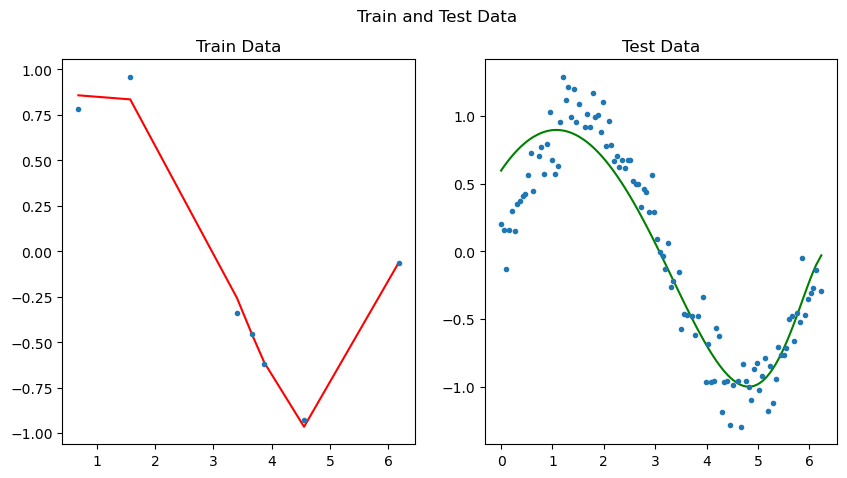

In [62]:
# putting the above figures side by side for comparision, using subplots
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Train and Test Data')
axs[0].plot(X_train[:, 0:1], X_train_scaled_1 @ GD_L1_w, 'r')
axs[0].plot(X_train[:, 0:1], y_train, '.')
axs[0].set_title('Train Data')
axs[1].plot(X_test[:, 0:1], X_test_scaled_1 @ GD_L1_w, 'g')
axs[1].plot(X_test[:, 0:1], y_test, '.')
axs[1].set_title('Test Data')
plt.show()


In [63]:
# output the final RMSE for the training and test set
gd_l1_rmse_train = math.sqrt(J_history[-1])
gd_l1_rmse_test = math.sqrt(test_J_history[-1])
print("Final training RMSE: ",gd_l1_rmse_train)
print("Final test RMSE: ", gd_l1_rmse_test)

Final training RMSE:  0.06350475355430224
Final test RMSE:  0.16760788143278407


## Using Lasso, Ridge in Sklearn below
There are L1 (Lasso) and L2 (Ridge) regularization methods available in scikit-learn, let's run them on our dataset

In [64]:
# use Ridge regression from sklearn to learn the model parameters
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.004, max_iter=10000)
ridge.fit(X_train_scaled, y_train)
print(f"Model parameters: {ridge.coef_} {ridge.intercept_}")



Model parameters: [ 0.68317146 -2.07864713 -1.01132877  0.1916362   0.76887686  0.87940349
  0.75488447  0.54324044  0.32025102  0.11897939 -0.04962267 -0.18499861
 -0.29087521 -0.37226435 -0.4340992 ] -0.09443169035226882


In [65]:
# output the final RMSE for the training and test set
ridge_rmse_train = math.sqrt(np.mean((ridge.predict(X_train_scaled) - y_train) ** 2))
ridge_rmse_test = math.sqrt(np.mean((ridge.predict(X_test_scaled) - y_test) ** 2))
print("Final training RMSE: ",ridge_rmse_train)
print("Final test RMSE: ", ridge_rmse_test)

Final training RMSE:  0.06859784497256215
Final test RMSE:  0.25930279992193495


In [66]:
# Use lasso regression from sklearn to learn the model parameters
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.004, max_iter=10000)
lasso.fit(X_train_scaled, y_train)
print(f"Model parameters: {lasso.coef_} {lasso.intercept_}")


Model parameters: [-0.         -1.27800488 -0.          0.          0.          0.
  0.57624013  0.49526164  0.          0.          0.          0.
  0.          0.          0.        ] -0.09443169035226888


In [67]:
# output the final RMSE for the training and test set
lasso_rmse_train = math.sqrt(np.mean((lasso.predict(X_train_scaled) - y_train) ** 2))
lasso_rmse_test = math.sqrt(np.mean((lasso.predict(X_test_scaled) - y_test) ** 2))
print("Final training RMSE: ",lasso_rmse_train)
print("Final test RMSE: ", lasso_rmse_test)

Final training RMSE:  0.11747428469868629
Final test RMSE:  0.3432830980957854


## Putting all together

In [68]:
#putting all the parameters from the above models in a dataframe, adding the bias term to the model parameters
# put the model parameters from gradient descent, linear regression and SGD in a dataframe
model_params = {'GD_L2': GD_L2_w, 'GD_L1': GD_L1_w, 'L2_Sklearn': np.append(ridge.intercept_, ridge.coef_), 'L1_Sklearn': np.append(lasso.intercept_, lasso.coef_)}
model_params_df = pd.DataFrame(model_params, index=['b']+ data.drop('y', axis=1).columns.tolist())
model_params_df


,GD_L2,GD_L1,L2_Sklearn,L1_Sklearn
b,-0.094432,-0.094432,-0.094432,-0.094432
x,0.682170,0.951377,0.683171,-0.000000
x_2,-2.075472,-3.064916,-2.078647,-1.278005
x_3,-1.012515,-0.000094,-1.011329,-0.000000
x_4,0.189048,0.000010,0.191636,0.000000
x_5,0.767435,1.217273,0.768877,0.000000
x_6,0.879652,1.105001,0.879403,0.000000
x_7,0.756340,0.062095,0.754884,0.576240
x_8,0.545186,0.000041,0.543240,0.495262
x_9,0.322088,-0.000030,0.320251,0.000000


In [69]:
# putting all the RMSE values in a dataframe
# put the RMSE values from gradient descent, linear regression and SGD in a dataframe
model_rmse = {'GD': [gd_rmse_train, gd_rmse_test], 'GD_L2': [gd_l2_rmse_train, gd_l2_rmse_test], 'GD_L1': [gd_l1_rmse_train, gd_l1_rmse_test], 'L2_Sklearn': [ridge_rmse_train, ridge_rmse_test], 'L1_Sklearn': [lasso_rmse_train, lasso_rmse_test]}
model_rmse_df = pd.DataFrame(model_rmse, index=['Train_RMSE', 'Test_RMSE'])
model_rmse_df

,GD,GD_L2,GD_L1,L2_Sklearn,L1_Sklearn
Train_RMSE,0.027505,0.069440,0.063505,0.068598,0.117474
Test_RMSE,0.223883,0.183871,0.167608,0.259303,0.343283


## Congratulations!
In this lab, you have:
* Extended the previous linear cost functions with a regularization term to prevent overfitting
* Implemented gradient descent with L1 and L2 regularizition for linear regression using Vectorization
* Utilized Lasso, Ridge from scikit-learn to implement regularized linear regression
* Compared the parameters learned from different approaches and their performance

## Reference:
Deeplearning.AI